# k-Means Experiment

Andrew McDonald // CSE 847 // 19 April 2021

k-means is a popular approach to unsupervised learning which clusters vector data into a pre-specified number of groups. As a prototype-based algorithm, k-means associates each cluster with a centroid. The centroid serves as a representative for all vectors in a cluster, and clusters consist of all vectors closer to one particular centroid than any other centroid.

More formally, given $N$ data points and $K$ clusters, the k-means approach to clustering aims to minimize the objective function

$$J = \min_{c_j, m_{ij}} \sum_{j=1}^{K} \sum_{i=1}^{N} m_{ij} \| x_i - c_j \|^2$$

where $x_i$ is a vector (data point), $c_j$ is the centroid of the $j$-th cluster, and $m_{ij}$ is an indicator variable which is 1 if $x_i$ belongs to cluster $j$ and 0 otherwise. Intuitively, k-means aims to minimize the squared distance of points from cluster centroids.


#### Experiment 1: Standard k-Means
In part 1, we implement the standard expectation maximization algorithm for k-means clustering, in which we alternate between updating cluster memberships $\{ m_{ij} \}$ given fixed centroids $\{c_j \}$:

$$m_{ij} \leftarrow \begin{cases} 1 & j = \text{argmin}_j  \| x_i - c_j \|^2\\ 0 & \text{else} \end{cases}$$

and updating centroids $\{c_j \}$ given fixed cluster memberships $\{ m_{ij} \}$:

$$c_j \leftarrow \frac{\sum_{i=1}^N m_{ij} x_i}{\sum_{i=1}^N m_{ij} }$$

#### Experiment 2: Spectral Relaxation of k-Means
In part 2, we implement the spectral relaxation of k-means clustering, in which we aim to minimize the cost of the partition $\Pi$, given by

$$Q(\Pi) = \text{trace}(XX^{\top}) - \text{trace}(Y^{\top} XX^{\top} Y)$$

where $X$ is our $N \times d$ data matrix of $d$-dimensional row vectors and $Y$ is an arbitrary $N \times k$ matrix satisfying $Y^{\top} Y = I_k$. Hence, our problem amounts to maximizing the trace of $Y^{\top} XX^{\top} Y$. Due to a theorem by Ky Fan, the maximum of this trace is given by

$$\lambda_1 + \ldots + \lambda_k = \max_{Y^{\top} Y = I_k} \text{trace}(Y^{\top} XX^{\top}Y)$$

for the symmetric matrix $XX^{\top}$ with eigenvalues $\lambda_i$, and the optimal $Y^*$ is given by the largest eigenvectors $Y^* = [u_1, \ldots, u_k]$ of $XX^{\top}$.

To recover the cluster assignments from this relaxation, we note that each row of $Y^*$ corresponds to a $k$-dimensional representation of each vector in the original $X$, and perform ordinary k-means clustering on the rows of $Y^*$ to assign rows to clusters.

We note that our presentation differs slightly from lecture, as we assume data vectors are rows in $X$, not columns. This aligns more closely with the formulation of other ML algorithms, e.g., linear regression. Hence, the $N \times N$ similarity matrix $XX^{\top}$ replaces the same $N\times N$ matrix which was $X^{\top} X$ in lecture.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs, make_circles, make_moons

#### Experiment 1: Standard k-Means

In [2]:
def k_means(X, k=3, max_iter=10, epsilon=1e-4, random_state=847, plot=False, subcall=False):
    """
    Perform k-means clustering on the row vectors of X with standard Euclidean distance.
    Utilize the standard EM algorithm to sequentially update centroids and assignments.
    Return assignments and centroids.

    :param k: [int] number of clusters to generate.
    :param X: [N x d numpy array] row vectors to be clustered.
    :param max_iter: [int] maximum number of iterations to perform EM.
    :param epsilon: [float] convergence tolerance of centroid change.
    :param random_state: [int] random seed used in dependencies.
    :param plot: [string] title of the dataset being clustered, for use in saving figures.
                          if False or empty "", does not plot.
    :param subcall: [bool] boolean indicating that the function is being called by another function.
                           used in deciding whether to save final figure.
    :return: [tuple] of length 2, where
        [0]: [N x 0 numpy array] of final cluster assignments.
        [1]: [k x d numpy array] of final centroids.
    """
    # initialize k cluster centers as random row vectors from X
    np.random.seed(random_state)
    centroids = X[np.random.choice(X.shape[0], k, replace=False), :]

    # initialize N cluster assignments, one for each vector
    assignments = np.zeros(X.shape[0])

    # initialize subplots
    fig, ax = plt.subplots(max_iter, 2, figsize=(4, max_iter*2))

    for i in range(max_iter):
        # (1) update cluster assignments
        # compute distances to centroids in vectorized manner
        # X is N x d and centroids.T is d x k, diffs is an N x d x k matrix of component-wise differences
        N, d = X.shape
        diffs = X.reshape(N, d, 1) - centroids.T.reshape(1, d, k)

        # squaring and summing diffs along d-dim axis gives an N x k matrix of distances
        distances = np.sum(diffs**2, axis=1)

        # assign each of N rows to nearest of k centroids
        assignments = np.argmin(distances, axis=1)

        # plot fixed centroids and new assignments
        if plot:
            ax[i, 0].scatter(x=X[:, 0], y=X[:, 1], c=assignments)
            ax[i, 0].scatter(x=centroids[:, 0], y=centroids[:, 1], c="k", marker="+")
            ax[i, 0].set_title(f"Assignment Update {i}")

        # (2) compute new centroids
        old_centroids = np.copy(centroids)
        for j in range(k):
            cluster = X[assignments == j]
            if len(cluster) > 0:
                centroids[j] = np.mean(cluster, axis=0)

        # plot fixed assignments and new centroids
        if plot:
            ax[i, 1].scatter(x=X[:, 0], y=X[:, 1], c=assignments)
            ax[i, 1].scatter(x=centroids[:, 0], y=centroids[:, 1], c="k", marker="+")
            ax[i, 1].set_title(f"Centroid Update {i}")

        # break if centroids did not change
        delta_centroid = np.linalg.norm(centroids - old_centroids)
        print(f"[KMeans] Centroid change: {delta_centroid}")
        if delta_centroid < epsilon:
            print(f"[KMeans] Converged after {i} iterations.")
            break

    if plot:
        # save current figure
        plt.tight_layout()
        plt.savefig(f"img/{plot}_intermediate.png")

        # save final figure if not being called by spectral relaxation
        if not subcall:

            # plot data in original space before clustering
            fig, ax = plt.subplots(2, 1, figsize=(4, 8))
            ax[0].scatter(x=X[:, 0], y=X[:, 1], c="k")
            ax[0].set_title(f"Ordinary k-Means: Input")

            # plot resulting clustering
            ax[1].scatter(x=X[:, 0], y=X[:, 1], c=assignments)
            ax[1].scatter(x=centroids[:, 0], y=centroids[:, 1], c="k", marker="+")
            ax[1].set_title(f"Ordinary k-Means: Result")

            plt.tight_layout()
            plt.savefig(f"img/{plot}_final.png")

    return assignments, centroids

[KMeans] Centroid change: 2.7626749175263186
[KMeans] Centroid change: 0.8572118299978224
[KMeans] Centroid change: 0.0
[KMeans] Converged after 2 iterations.


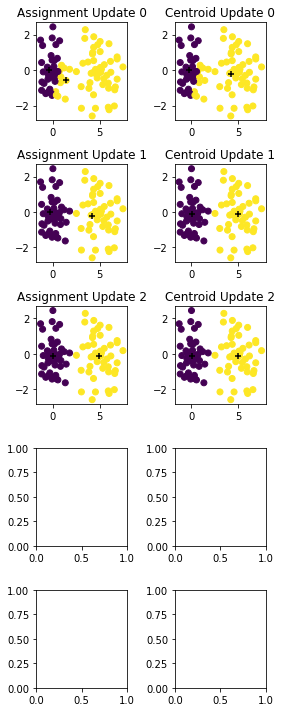

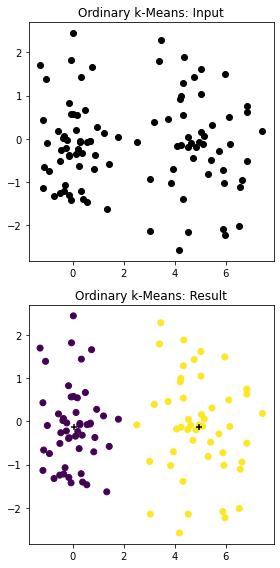

In [3]:
# test with small k globular dataset
k = 2
centers = np.array([[0, 0], [5, 0]])
X = make_blobs(n_samples=100, n_features=2, centers=centers, cluster_std=1, random_state=847)[0]
_ = k_means(X, k, max_iter=5, plot="kmeans_k2_blobs")

[KMeans] Centroid change: 3.2318876256738087
[KMeans] Centroid change: 0.4895982298229152
[KMeans] Centroid change: 0.37251748564719117
[KMeans] Centroid change: 0.4870199719697072
[KMeans] Centroid change: 0.6849821482329906
[KMeans] Centroid change: 1.3546493896388692
[KMeans] Centroid change: 2.370912692046867
[KMeans] Centroid change: 0.788767834065728
[KMeans] Centroid change: 0.15393043794460584
[KMeans] Centroid change: 0.0
[KMeans] Converged after 9 iterations.


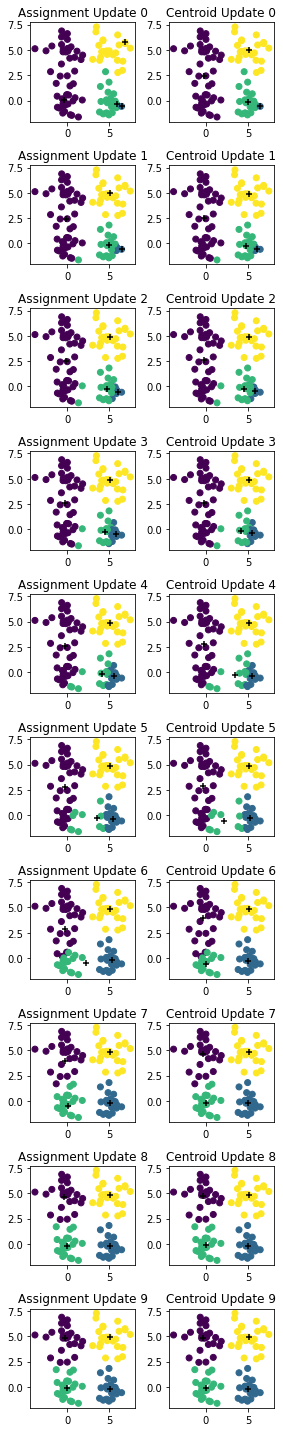

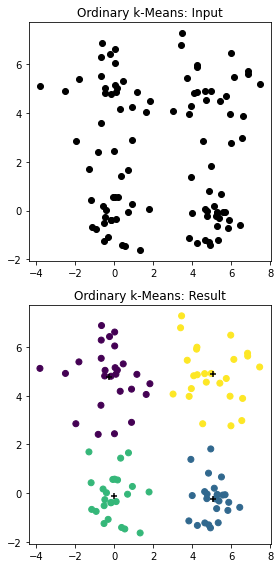

In [4]:
# test with moderate k globular dataset
k = 4
centers = np.array([[0, 0], [5, 0], [0, 5], [5, 5]])
X = make_blobs(n_samples=100, n_features=2, centers=centers, cluster_std=1, random_state=847)[0]
_ = k_means(X, k, max_iter=10, plot="kmeans_k4_blobs")

[KMeans] Centroid change: 6.862483025438282
[KMeans] Centroid change: 4.282857579990492
[KMeans] Centroid change: 0.9180283953890692
[KMeans] Centroid change: 0.0
[KMeans] Converged after 3 iterations.


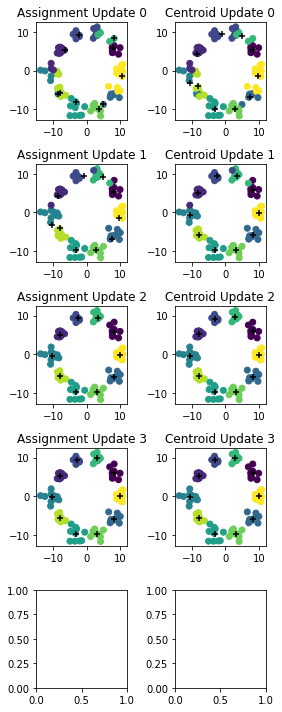

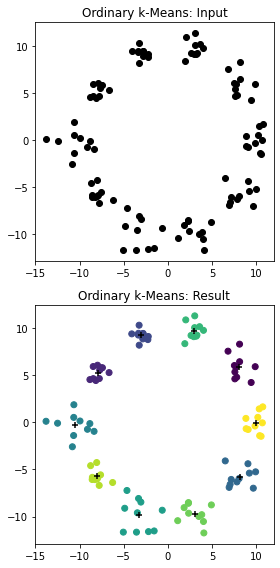

In [5]:
# test with large k globular dataset
k = 10
centers = np.array([[10*np.cos(2*np.pi*i/k), 10*np.sin(2*np.pi*i/k)] for i in range(k)])
X = make_blobs(n_samples=100, n_features=2, centers=centers, cluster_std=1, random_state=847)[0]
_ = k_means(X, k, max_iter=5, plot="kmeans_k10_blobs")

[KMeans] Centroid change: 0.4063917605311162
[KMeans] Centroid change: 0.12790377349093493
[KMeans] Centroid change: 0.05306620260108053
[KMeans] Centroid change: 0.0
[KMeans] Converged after 3 iterations.


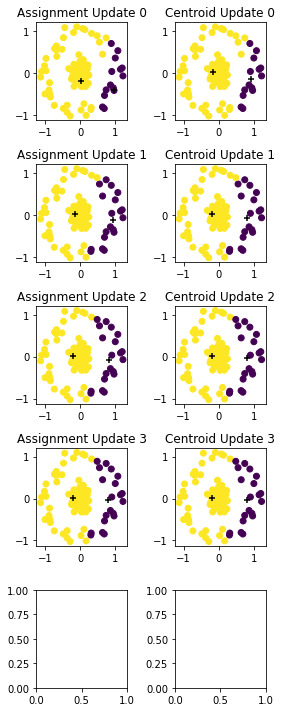

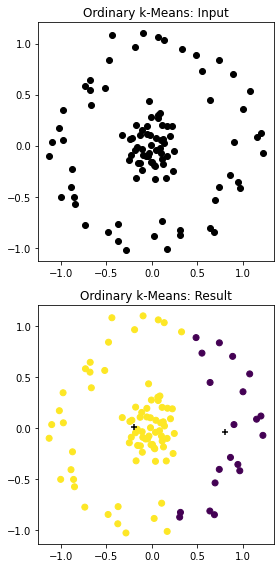

In [6]:
# test with circles dataset
k = 2
X = make_circles(n_samples=100, factor=0.2, noise=0.1, random_state=847)[0]
_ = k_means(X, k, max_iter=5, plot="kmeans_k2_circles")

[KMeans] Centroid change: 0.9288886156931477
[KMeans] Centroid change: 0.05601927898573082
[KMeans] Centroid change: 0.02739273998314323
[KMeans] Centroid change: 0.02653489359011095
[KMeans] Centroid change: 0.0
[KMeans] Converged after 4 iterations.


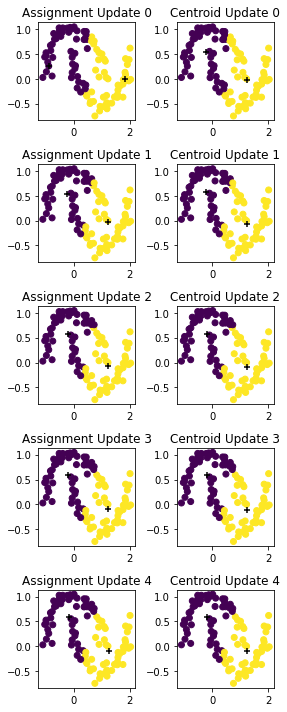

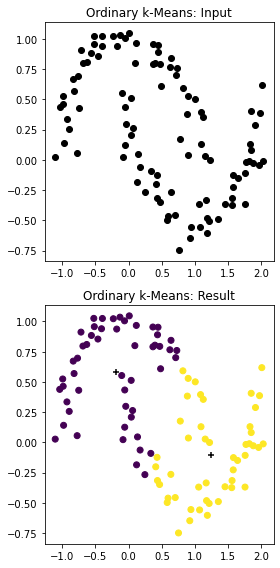

In [7]:
# test with moons dataset
k = 2
X = make_moons(n_samples=100, noise=0.1, random_state=847)[0]
_ = k_means(X, k, max_iter=5, plot="kmeans_k2_moons")

#### Experiment 2: Spectral Relaxation of k-Means

In [8]:
def k_means_spectral(X, k=3, max_iter=10, epsilon=1e-4, random_state=847, plot=False):
    """
    Perform spectrally-relaxed k-means clustering on the row vectors of X.
    Call ordinary k_means following eigendecomposition.
    Return assignments and centroids.

    :param k: [int] number of clusters to generate.
    :param X: [N x d numpy array] row vectors to be clustered.
    :param max_iter: [int] maximum number of iterations to perform EM.
    :param epsilon: [float] convergence tolerance of centroid change.
    :param random_state: [int] random seed used in dependencies.
    :param plot: [string] title of the dataset being clustered, for use in saving figures.
                          if False or empty "", does not plot.
    :return: [tuple] of length 2, where
        [0]: [N x 0 numpy array] of final cluster assignments.
        [1]: [k x d numpy array] of final centroids.
    """
    # compute eigendecomposition of XXT
    # note that formulation in notes assumes column vectors x_i in X, but
    # we assume row vectors x_i.T in X, i.e., a standard N x d design matrix
    XXT = np.dot(X, X.T)
    evals, evecs = np.linalg.eig(XXT)
    evecs, evals = np.real(evecs), np.real(evals)
    k_evecs = evecs[:, :k]

    # perform ordinary k-means clustering on N rows of first k eigenvectors
    print(f"[SpectralKMeans] Computed eigendecomposition.")
    print(f"[SpectralKMeans] Calling ordinary k-means on first k eigenvectors.")
    assignments, _ = k_means(k_evecs, k=k, max_iter=max_iter, epsilon=epsilon,
                             random_state=random_state, plot=plot, subcall=True)
    print(f"[SpectralKMeans] Result returned from ordinary k-means.")

    # manually compute centroids in original data space: returned centroids are in spectral space
    centroids = np.zeros((k, X.shape[1]))
    for j in range(k):
        cluster = X[assignments == j]
        if len(cluster) > 0:
            centroids[j] = np.mean(cluster, axis=0)


    if plot:
        # plot data in original space before spectral-space clustering
        fig, ax = plt.subplots(2, 1, figsize=(4, 8))
        ax[0].scatter(x=X[:, 0], y=X[:, 1], c="k")
        ax[0].set_title(f"Spectral k-Means: Input")

        # plot resulting clustering
        ax[1].scatter(x=X[:, 0], y=X[:, 1], c=assignments)
        ax[1].scatter(x=centroids[:, 0], y=centroids[:, 1], c="k", marker="+")
        ax[1].set_title(f"Spectral k-Means: Result")
        plt.tight_layout()
        plt.savefig(f"img/{plot}_final.png")

    return assignments, centroids

[SpectralKMeans] Computed eigendecomposition.
[SpectralKMeans] Calling ordinary k-means on first k eigenvectors.
[KMeans] Centroid change: 0.09388123703230129
[KMeans] Centroid change: 0.02191101594934092
[KMeans] Centroid change: 0.01519237319761128
[KMeans] Centroid change: 0.013001833912046306
[KMeans] Centroid change: 0.014849614149983103
[KMeans] Centroid change: 0.015240369423143902
[KMeans] Centroid change: 0.0076335306373651705
[KMeans] Centroid change: 0.003508788911296022
[KMeans] Centroid change: 0.0029842706330272107
[KMeans] Centroid change: 0.0
[KMeans] Converged after 9 iterations.
[SpectralKMeans] Result returned from ordinary k-means.


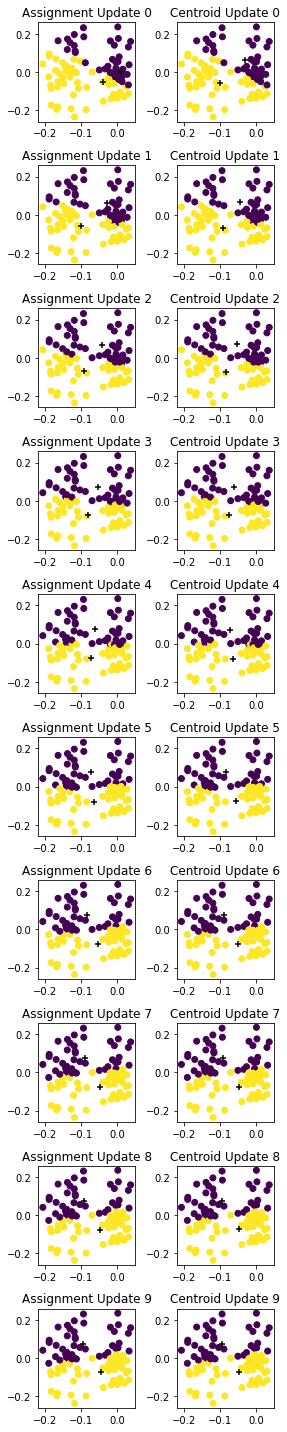

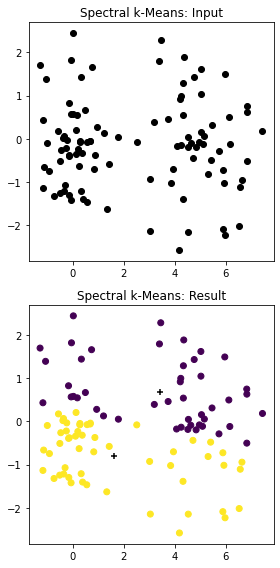

In [9]:
# test with small k globular dataset
k = 2
centers = np.array([[0, 0], [5, 0]])
X = make_blobs(n_samples=100, n_features=2, centers=centers, cluster_std=1, random_state=847)[0]
_ = k_means_spectral(X, k, max_iter=10, plot="spectral_k2_blobs")

[SpectralKMeans] Computed eigendecomposition.
[SpectralKMeans] Calling ordinary k-means on first k eigenvectors.
[KMeans] Centroid change: 0.16847219178982406
[KMeans] Centroid change: 0.08642650075116018
[KMeans] Centroid change: 0.04758853887424791
[KMeans] Centroid change: 0.07071448820056761
[KMeans] Centroid change: 0.059903259567627244
[KMeans] Centroid change: 0.027690555524788843
[KMeans] Centroid change: 0.025895262024227598
[KMeans] Centroid change: 0.0
[KMeans] Converged after 7 iterations.
[SpectralKMeans] Result returned from ordinary k-means.


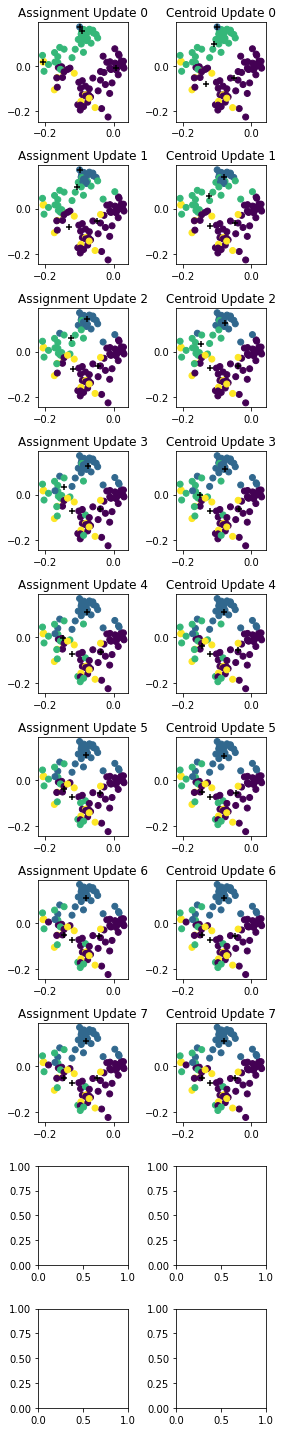

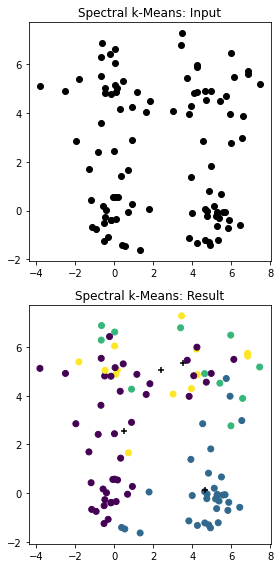

In [10]:
# test with moderate k globular dataset
k = 4
centers = np.array([[0, 0], [5, 0], [0, 5], [5, 5]])
X = make_blobs(n_samples=100, n_features=2, centers=centers, cluster_std=1, random_state=847)[0]
_ = k_means_spectral(X, k, max_iter=10, plot="spectral_k4_blobs")

[SpectralKMeans] Computed eigendecomposition.
[SpectralKMeans] Calling ordinary k-means on first k eigenvectors.
[KMeans] Centroid change: 0.4599727402472371
[KMeans] Centroid change: 0.08864447423267999
[KMeans] Centroid change: 0.035900049705859007
[KMeans] Centroid change: 0.033728731047705816
[KMeans] Centroid change: 0.035695454050940545
[KMeans] Centroid change: 0.04210567269733847
[KMeans] Centroid change: 0.0709844278657572
[KMeans] Centroid change: 0.0
[KMeans] Converged after 7 iterations.
[SpectralKMeans] Result returned from ordinary k-means.


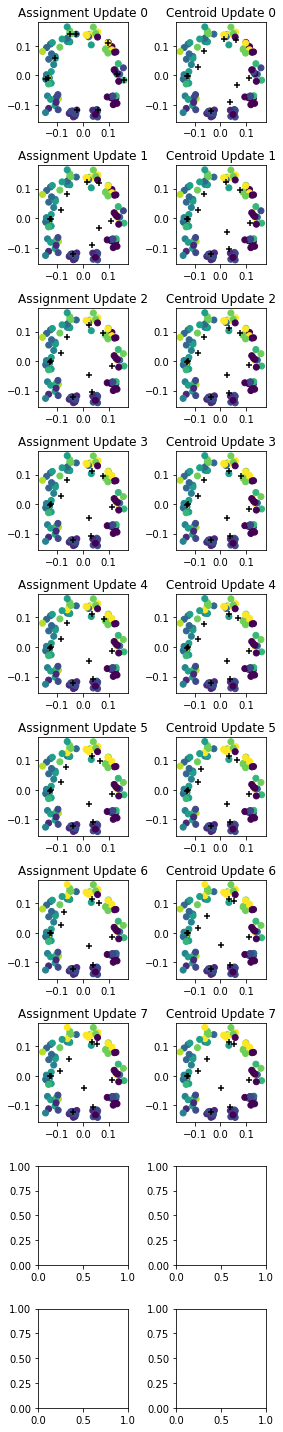

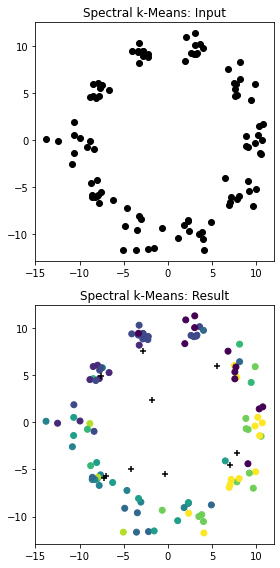

In [11]:
# test with large k globular dataset
k = 10
centers = np.array([[10*np.cos(2*np.pi*i/k), 10*np.sin(2*np.pi*i/k)] for i in range(k)])
X = make_blobs(n_samples=100, n_features=2, centers=centers, cluster_std=1, random_state=847)[0]
_ = k_means_spectral(X, k, max_iter=10, plot="spectral_k10_blobs")

[SpectralKMeans] Computed eigendecomposition.
[SpectralKMeans] Calling ordinary k-means on first k eigenvectors.
[KMeans] Centroid change: 0.08190683503707571
[KMeans] Centroid change: 0.018869887827719343
[KMeans] Centroid change: 0.009248378404748745
[KMeans] Centroid change: 0.0
[KMeans] Converged after 3 iterations.
[SpectralKMeans] Result returned from ordinary k-means.


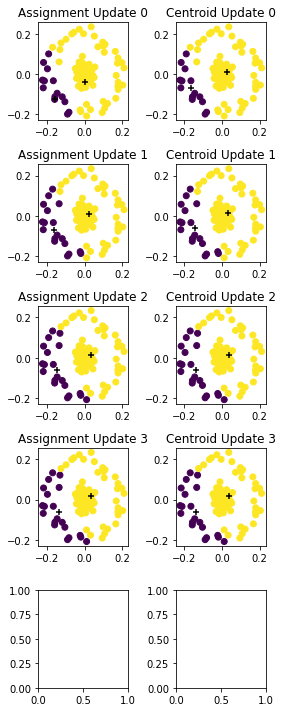

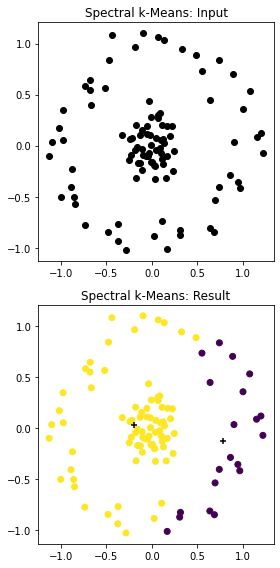

In [12]:
# test with circles dataset
k = 2
X = make_circles(n_samples=100, factor=0.2, noise=0.1, random_state=847)[0]
_ = k_means_spectral(X, k, max_iter=5, plot="spectral_k2_circles")

[SpectralKMeans] Computed eigendecomposition.
[SpectralKMeans] Calling ordinary k-means on first k eigenvectors.
[KMeans] Centroid change: 0.10551898943243981
[KMeans] Centroid change: 0.02747759593373699
[KMeans] Centroid change: 0.0038879988113484794
[KMeans] Centroid change: 0.0029989489549988157
[KMeans] Centroid change: 0.0
[KMeans] Converged after 4 iterations.
[SpectralKMeans] Result returned from ordinary k-means.


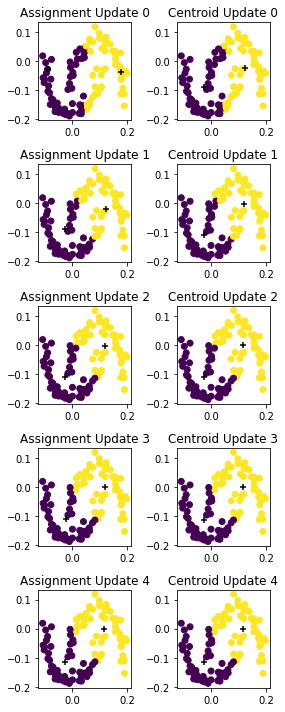

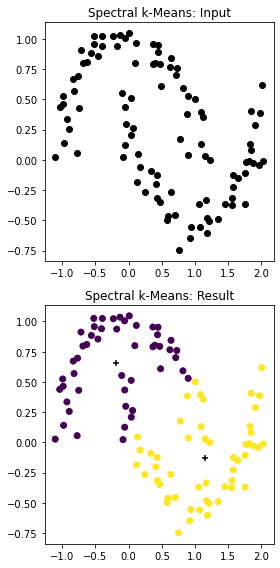

In [13]:
# test with moons dataset
k = 2
X = make_moons(n_samples=100, noise=0.1, random_state=847)[0]
_ = k_means_spectral(X, k, max_iter=5, plot="spectral_k2_moons")
